In [1]:
from datetime import datetime, timedelta
import intake

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import metpy.calc as mpcalc

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


# --- define specific heats of interest
cp = 1004   # J / kg K
Lv = 2.5e6  # J / kg
g  = 9.81   # m/s2  

In [2]:
## ceilometer during EU
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__EUREC4A.nc"
ceilo_eu = xr.open_dataset(path_to_ceilo)
ceilo_eu['time'] = ceilo_eu['time'].astype('datetime64[ns]')
ceilo_eu = ceilo_eu.sortby('time')
# ceilo = ceilo.sel(time=slice('2020-02-01','2020-02-18'))


## ceilometer during OR
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202408.nc"
ceilo1 = xr.open_dataset(path_to_ceilo)
path_to_ceilo = "/work/pd1327/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/A_Cloud_base_heights/CEILO__CHM15k_MPI__CBH__10s__202409.nc"
ceilo2 = xr.open_dataset(path_to_ceilo)
ceilo_or = xr.concat([ceilo1, ceilo2], dim="time")

ceilo_or['time'] = ceilo_or['time'].astype('datetime64[ns]')
ceilo_or = ceilo_or.sortby('time')

/tmp/ipykernel_746233/1358912245.py:14: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ceilo_or = xr.concat([ceilo1, ceilo2], dim="time")


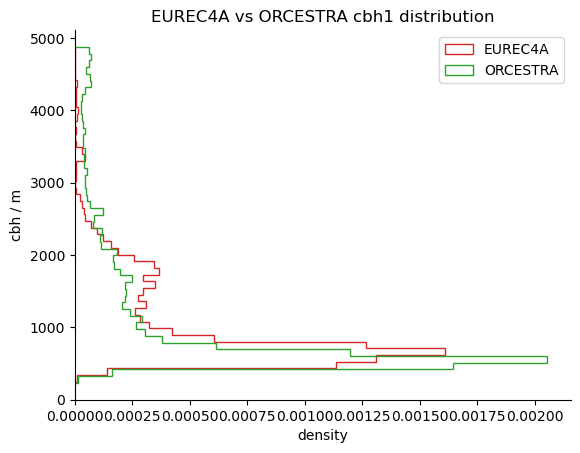

In [3]:
fig, ax = plt.subplots(1,1)

ceilo_eu["cbh_1"].plot.hist(
    ax=ax,
    bins=50,
    density=True,          
    orientation="horizontal",
    histtype="step",
    color="tab:red",
    label="EUREC4A"
)


ceilo_or["cbh_1"].plot.hist(
    ax=ax,
    bins=50,
    density=True,          
    orientation="horizontal", 
    histtype="step",
    color="tab:green", 
    label="ORCESTRA"
)

ax.set_title("EUREC4A vs ORCESTRA cbh1 distribution")
ax.set_ylabel("cbh / m")
ax.set_xlabel("density")

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.legend()

plt.show()

#### open radiosondes

In [36]:
## open RAPSODI dataset - selecting only ascending RS from BCO
rs_orcestra = xr.open_dataset("ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
rs_orcestra_bco = rs_orcestra.where(((rs_orcestra["platform"] == "BCO")&(rs_orcestra["ascent_flag"]==0)), drop=True)

# select profiles above 20 m
rs_orcestra_bco = rs_orcestra_bco.where(rs_orcestra_bco.height>40, drop=True)



## open EUREC4A soundings dataset - selecting only ascending RS from BCO
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

rs_eureca = xr.open_dataset(level2_path)
rs_eureca_bco = rs_eureca.where((rs_eureca.platform==1)&(rs_eureca["ascent_flag"]==1) , drop=True)

# select profiles above 20 m
rs_eureca_bco = rs_eureca_bco.where(rs_eureca_bco.alt>40, drop=True)

# RENAME sounding into LAUNCH_TIME
rs_eureca_bco = rs_eureca_bco.swap_dims({"sounding": "launch_time"})

##### window ceilometer

In [34]:
dt = pd.Timedelta("1H")

time = ceilo_eu["cbh_1"].time
launch = rs_eureca_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time

cbh_eu = ceilo_eu["cbh_1"].clip(max=1000)  ## does this clipping make sense?

cbh_windowed_eu = cbh_eu.expand_dims(launch_time=launch).where(mask)
cbh_quantiles_eu = cbh_windowed_eu.quantile(
    q=[0.0, 0.05, 0.1],
    dim="time",
    skipna=True
)


time = ceilo_or["cbh_1"].time
launch = rs_orcestra_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time

cbh_or = ceilo_or["cbh_1"].clip(max=1000)  ## does this clipping make sense?

cbh_windowed_or = cbh_or.expand_dims(launch_time=launch).where(mask)
cbh_quantiles_or = cbh_windowed_or.quantile(
    q=[0.0, 0.05, 0.1],
    dim="time",
    skipna=True
)

/tmp/ipykernel_746233/1840681673.py:1: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  dt = pd.Timedelta("1H")
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


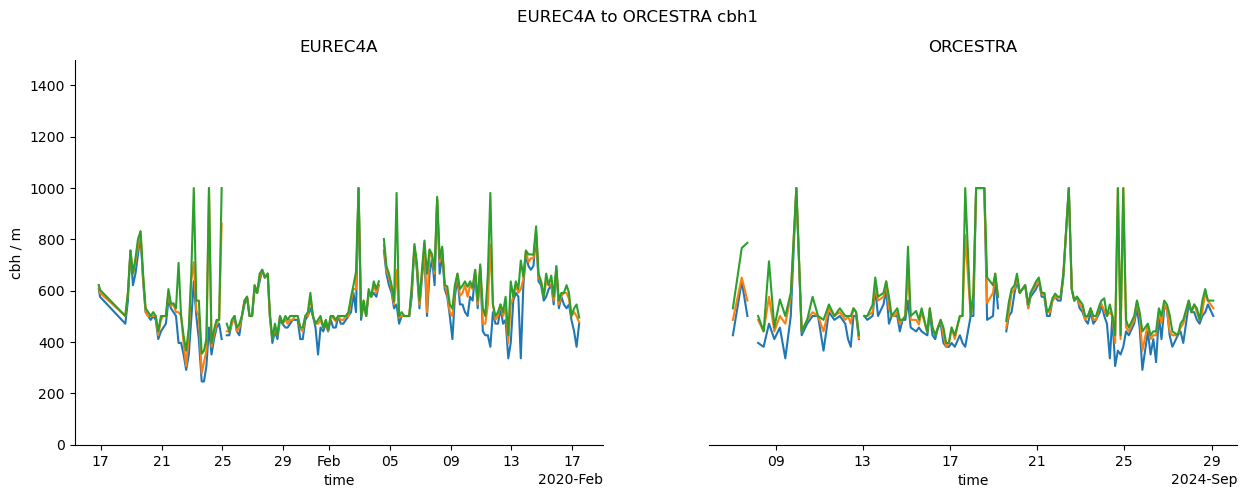

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUREC4A to ORCESTRA cbh1")

# ceilo_eu["cbh_1"].plot.scatter(
#     ax=ax[0],
#     x="time",
#     color="tab:red",
#     label="EUREC4A"
# )
# 

# ceilo_or["cbh_1"].plot.scatter(
#     ax=ax[1],
#     x="time",
#     color="tab:green", 
#     label="ORCESTRA"
# )

cbh_quantiles_eu.isel(quantile=0).plot(ax=ax[0], x="launch_time")
cbh_quantiles_eu.isel(quantile=1).plot(ax=ax[0], x="launch_time")
cbh_quantiles_eu.isel(quantile=2).plot(ax=ax[0], x="launch_time")
ax[0].set_ylabel("cbh / m")
ax[0].set_title("EUREC4A")


cbh_quantiles_or.isel(quantile=0).plot(ax=ax[1], x="launch_time")
cbh_quantiles_or.isel(quantile=1).plot(ax=ax[1], x="launch_time")
cbh_quantiles_or.isel(quantile=2).plot(ax=ax[1], x="launch_time")

ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].set_title("ORCESTRA")



for x in ax:
    x.set_ylim(0,1500)
    x.set_xlabel("time")
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)

# ax.legend()

plt.show()

### LCL from surface

In [7]:
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


## eurec4a
start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")

wxt_eu = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt_eu = wxt_eu.sel(time=slice(start,end))


## orcestra
start, end = rs_orcestra_bco.launch_time[0] - pd.Timedelta("2H"), rs_orcestra_bco.launch_time[-1] + pd.Timedelta("2H")

wxt_or = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt_or = wxt_or.sel(time=slice(start,end))

/tmp/ipykernel_746233/3270844921.py:5: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start, end = rs_eureca_bco.launch_time[0] - pd.Timedelta("2H"), rs_eureca_bco.launch_time[-1] + pd.Timedelta("2H")
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/tmp/ipykernel_746233/3270844921.py:12: Pandas4Warning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  start, end = rs_orcestra_bco.launch_time[0] - pd.Timedelta("2H"), rs_orcestra_bco.launch_time[-1] + pd.Timedelta("2H")


In [8]:
## compute LCL here
import metpy.calc as mpcalc
from metpy.units import units


#########   EUREC4A  ##########

# Ensure xarray + pint units
temp_q = wxt_eu['T'].metpy.quantify()

######## debug RH ########
rh = wxt_eu['RH']
rh.attrs["units"] = "%"
rh_q = rh.metpy.quantify()
######## debug RH ########
p_q = wxt_eu['P'].metpy.quantify()

# Compute dewpoint: stays xarray with same dims
dp = mpcalc.dewpoint_from_relative_humidity(temp_q, rh_q)

# Compute LCL: returns two xarray DataArrays with same dims as temp
lcl_p, lcl_T = mpcalc.lcl(p_q, temp_q, dp)

# Convert LCL pressure to height — returns pint.Quantity, NOT xarray
lcl_h_eu = mpcalc.pressure_to_height_std(lcl_p)

# Convert to meters
lcl_h_eu = lcl_h_eu.to(units.meter)

# --- FIX: rewrap into DataArray using the original coords ---
lcl_h_eu = xr.DataArray(
    lcl_h_eu.m,  # magnitude
    coords=temp_q.coords,
    dims=temp_q.dims,
    name='lcl_height'
)  #.metpy.quantify()  # restore pint units inside xarray




######### ORCESTRA  #########
# Ensure xarray + pint units
temp_q = wxt_or['T'].metpy.quantify()

######## debug RH ########
rh = wxt_or['RH']
rh.attrs["units"] = "%"
rh_q = rh.metpy.quantify()
######## debug RH ########
p_q = wxt_or['P'].metpy.quantify()

# Compute dewpoint: stays xarray with same dims
dp = mpcalc.dewpoint_from_relative_humidity(temp_q, rh_q)

# Compute LCL: returns two xarray DataArrays with same dims as temp
lcl_p, lcl_T = mpcalc.lcl(p_q, temp_q, dp)

# Convert LCL pressure to height — returns pint.Quantity, NOT xarray
lcl_h_or = mpcalc.pressure_to_height_std(lcl_p)

# Convert to meters
lcl_h_or = lcl_h_or.to(units.meter)

# --- FIX: rewrap into DataArray using the original coords ---
lcl_h_or = xr.DataArray(
    lcl_h_or.m,  # magnitude
    coords=temp_q.coords,
    dims=temp_q.dims,
    name='lcl_height'
) 

In [9]:
## EUREC4A


time = lcl_h_eu.time
launch = rs_eureca_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time


lcl_windowed_eu = lcl_h_eu.expand_dims(launch_time=launch).where(mask)
lcl_quantile_eu = lcl_windowed_eu.quantile(
    q=[0.0, 0.05, 0.1],
    dim="time",
    skipna=True
)




## ORCESTRA

time = lcl_h_or.time
launch = rs_orcestra_bco.launch_time

mask = (abs(time - launch) <= dt)    ## select ceilometer data, 60 minutes windows centred on launch_time


lcl_windowed_or = lcl_h_or.expand_dims(launch_time=launch).where(mask)
lcl_quantile_or = lcl_windowed_or.quantile(
    q=[0.0, 0.05, 0.1],
    dim="time",
    skipna=True
)

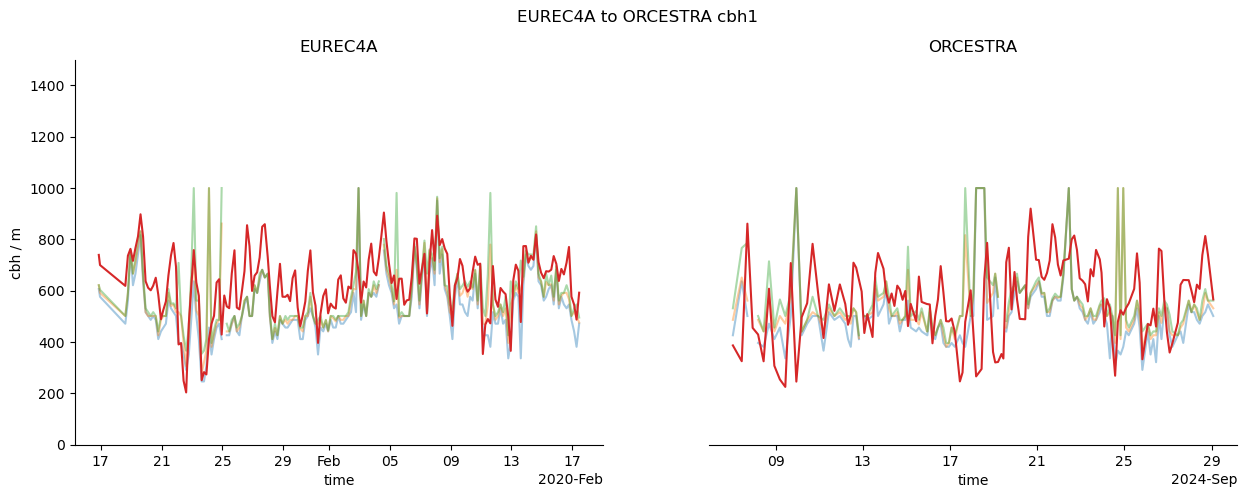

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUREC4A to ORCESTRA cbh1")


cbh_quantiles_eu.isel(quantile=0).plot(ax=ax[0], x="launch_time", alpha=0.4)
cbh_quantiles_eu.isel(quantile=1).plot(ax=ax[0], x="launch_time", alpha=0.4)
cbh_quantiles_eu.isel(quantile=2).plot(ax=ax[0], x="launch_time", alpha=0.4)
lcl_quantile_eu.isel(quantile=1).plot(ax=ax[0], x="launch_time", label = "LCL")
ax[0].set_ylabel("cbh / m")
ax[0].set_title("EUREC4A")


cbh_quantiles_or.isel(quantile=0).plot(ax=ax[1], x="launch_time", alpha=0.4)
cbh_quantiles_or.isel(quantile=1).plot(ax=ax[1], x="launch_time", alpha=0.4)
cbh_quantiles_or.isel(quantile=2).plot(ax=ax[1], x="launch_time", alpha=0.4)
lcl_quantile_or.isel(quantile=1).plot(ax=ax[1], x="launch_time", label = "LCL")

ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].set_title("ORCESTRA")



for x in ax:
    x.set_ylim(0,1500)
    x.set_xlabel("time")
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)

# ax.legend()

plt.show()

In [ ]:
# (rs_eureca_bco.p.diff(dim="alt") > 0).idxmax(dim="alt")

# rs_eureca_bco.p.isel(alt=slice(38, 42), launch_time=0)

mask = rs_eureca_bco.p.sel(alt=slice(40, 3000)).isnull()  #p.diff(dim="height") > 0

true_points = mask.stack(z=("alt", "launch_time"))
true_points = true_points.where(true_points, drop=True)

true_points.z.values



mask = rs_orcestra_bco.p.sel(height=slice(40, 3000)).isnull()  #p.diff(dim="height") > 0

true_points_or = mask.stack(z=("height", "launch_time"))
true_points_or = true_points_or.where(true_points_or, drop=True)

# true_points_or.z.values


array([(60.0, Timestamp('2024-09-14 14:02:41.390100992')),
       (330.0, Timestamp('2024-09-15 22:49:47.567048')),
       (340.0, Timestamp('2024-09-15 22:49:47.567048')),
       (350.0, Timestamp('2024-09-15 22:49:47.567048')),
       (360.0, Timestamp('2024-09-15 22:49:47.567048')),
       (370.0, Timestamp('2024-09-15 22:49:47.567048')),
       (380.0, Timestamp('2024-09-15 22:49:47.567048')),
       (390.0, Timestamp('2024-09-15 22:49:47.567048')),
       (400.0, Timestamp('2024-09-15 22:49:47.567048')),
       (410.0, Timestamp('2024-09-15 22:49:47.567048')),
       (420.0, Timestamp('2024-09-15 22:49:47.567048')),
       (430.0, Timestamp('2024-09-15 22:49:47.567048')),
       (440.0, Timestamp('2024-09-15 22:49:47.567048')),
       (450.0, Timestamp('2024-09-15 22:49:47.567048')),
       (460.0, Timestamp('2024-09-15 22:49:47.567048')),
       (470.0, Timestamp('2024-09-15 22:49:47.567048')),
       (480.0, Timestamp('2024-09-15 22:49:47.567048')),
       (490.0, Timestamp('202

In [84]:
import numpy as np
ccl_values_or = {'ccl':[], 'launch_time':[t.values for t in rs_orcestra_bco.launch_time]}
ccl_values_eu = {'ccl':[], 'launch_time':[t.values for t in rs_eureca_bco.launch_time]}


for t in rs_orcestra_bco.launch_time:
    if t in [true_points_or.z.values[0][1], true_points_or.z.values[1][1]]:
        ccl_values_or["ccl"].append(np.nan)
        continue
    prof = rs_orcestra_bco.sel(launch_time=t, height=slice(40, 3e3)).dropna(dim="height")

    prof = prof.sortby("p", ascending=False)

    ccl_p, ccl_T, _ = mpcalc.ccl(
        prof.p.metpy.quantify(),
        prof.ta.metpy.quantify(),
        prof.dp.metpy.quantify(),
    )
    ccl_or = mpcalc.pressure_to_height_std(ccl_p)*1000  ## output is in km !!!
    ccl_values_or["ccl"].append(ccl_or.magnitude)


for t in rs_eureca_bco.launch_time:
    # if t in [true_points.z.values[0][1], true_points.z.values[1][1]]:
    #     ccl_values_eu["ccl"].append(np.nan)
    #     continue
    prof = rs_eureca_bco.sel(launch_time=t, alt=slice(40, 3e3)).dropna(dim="alt")

    prof = prof.sortby("p", ascending=False)

    ccl_p, ccl_T, _ = mpcalc.ccl(
        prof.p.metpy.quantify(),
        prof.ta.metpy.quantify(),
        prof.dp.metpy.quantify(),
    )
    ccl_eu = mpcalc.pressure_to_height_std(ccl_p)*1000  ## output is in km !!!
    ccl_values_eu["ccl"].append(ccl_eu.magnitude)

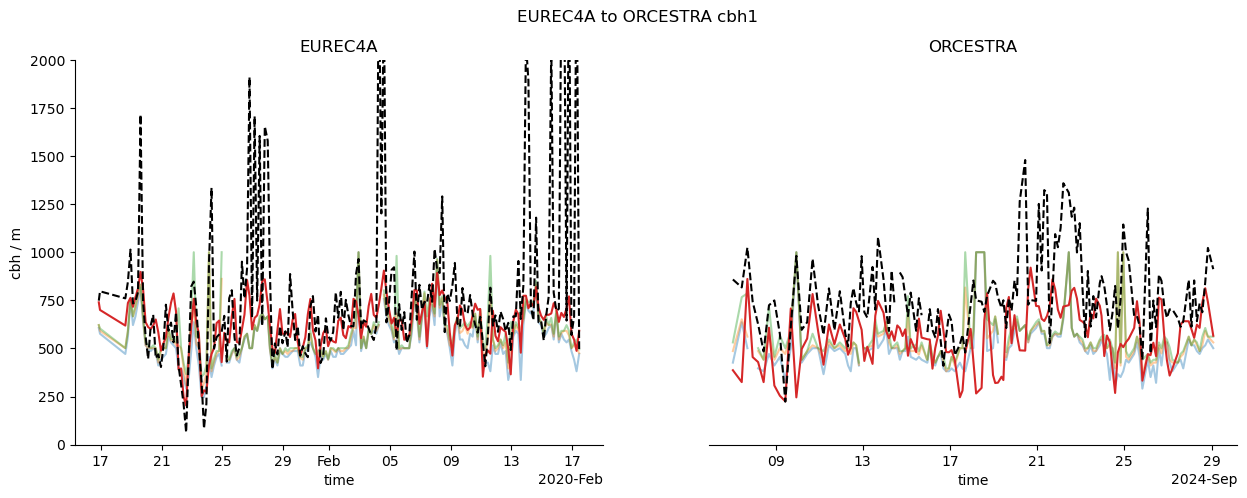

In [86]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUREC4A to ORCESTRA cbh1")

## EUREC4A
cbh_quantiles_eu.isel(quantile=0).plot(ax=ax[0], x="launch_time", alpha=0.4)
cbh_quantiles_eu.isel(quantile=1).plot(ax=ax[0], x="launch_time", alpha=0.4)
cbh_quantiles_eu.isel(quantile=2).plot(ax=ax[0], x="launch_time", alpha=0.4)
lcl_quantile_eu.isel(quantile=1).plot(ax=ax[0], x="launch_time", label = "LCL")

ax[0].plot(ccl_values_eu['launch_time'], ccl_values_eu["ccl"], "--k")

ax[0].set_ylabel("cbh / m")
ax[0].set_title("EUREC4A")


## ORCESTRA
cbh_quantiles_or.isel(quantile=0).plot(ax=ax[1], x="launch_time", alpha=0.4)
cbh_quantiles_or.isel(quantile=1).plot(ax=ax[1], x="launch_time", alpha=0.4)
cbh_quantiles_or.isel(quantile=2).plot(ax=ax[1], x="launch_time", alpha=0.4)
lcl_quantile_or.isel(quantile=1).plot(ax=ax[1], x="launch_time", label = "LCL")

ax[1].plot(ccl_values_or['launch_time'], ccl_values_or["ccl"], "--k")

ax[1].spines["left"].set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].set_title("ORCESTRA")



for x in ax:
    x.set_ylim(0,2000)
    x.set_xlabel("time")
    for spine in ['top', 'right']:
        x.spines[spine].set_visible(False)

# ax.legend()

plt.show()

#### CCL seems not to be a good metric

#### radio profiles

In [ ]:
## --- I downloaded the Level 2 version of EUREC4A profiles
level2_path = "/work/mh1498/m301248/TCO_data/eurec4a_profiles_level2/EUREC4A_BCO_Vaisala-RS_L2_v3.0.0.nc"

import xarray as xr

ds = xr.open_dataset(level2_path)
# Create boolean index for soundings where month == 2
mask = ds.launch_time.dt.month == 2

# Select along 'sounding' dimension
ds_filtered = ds.sel(sounding=mask)
ds_filtered


# compute MSE* from radio profiles
MSE_pr_sat  = cp*(ds_filtered["ta"]) + g * ds_filtered.alt + Lv*(ds_filtered["mr"]/ds_filtered["rh"])


# - run computations for radiosonde profiles
alt_pr = ds_filtered.alt
alt_mask = (alt_pr < highest_level) & (alt_pr > lowest_level)
alt_pr = alt_pr[alt_mask]

mse_pr_sat_mean = MSE_pr_sat.mean(dim="sounding", skipna=True)
mse_pr_sat_std = MSE_pr_sat.std(dim="sounding", skipna=True)
mse_pr_sat_mean = mse_pr_sat_mean[alt_mask]


In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,6))

# ---- Original plots on the main axes (ax1) ----
ax1.plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
ax1.fill_betweenx(alt_pr,
                  (mse_pr_sat_mean - mse_pr_sat_std)/1e3,
                  (mse_pr_sat_mean + mse_pr_sat_std)/1e3,
                  color="tab:red", alpha=0.1)

ax1.plot(MSE_sat_day_mean/1e3, MSE_sat_day.alt, color="tab:blue", label="coral mean")
ax1.fill_betweenx(MSE_sat_day.alt,
                  (MSE_sat_day_mean - MSE_sat_day_std)/1e3,
                  (MSE_sat_day_mean + MSE_sat_day_std)/1e3,
                  color="tab:blue", alpha=0.1)

ax1.plot(era5_mseSat_mean/1e3, height, color="k", label="ERA5 mean")
ax1.fill_betweenx(height,
                  (era5_mseSat_mean - era5_mseSat_std)/1e3,
                  (era5_mseSat_mean + era5_mseSat_std)/1e3,
                  color="k", alpha=0.1)

ax1.set_ylim(0, 2500)
ax1.set_xlim(325,360)
ax1.set_xlabel("MSE [kJ/kg]")
ax1.set_ylabel("Altitude [m]")

# ---- Secondary x-axis on top for CBH ----
ax2 = ax1.twiny()
cbh_hr.plot.scatter(ax=ax2)
ax2.set_xlabel("CBH [m]")

# ---- plot LCL ----
ax2.plot(cbh_hr.time, lcl_h_hr, color="tab:orange", label='LCL')

# ---- Legends ----
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc="upper left")

plt.show()


: 

In [1]:
wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt = wxt.sel(time=slice('2020-02-01','2020-02-18'))

temp = wxt['T'] + 273.15  ## deg K
rh   = wxt['RH']/100.     ## values betwen 0 and 1

sfc_pressure = wxt['P']   ## already in hPa


NameError: name 'cat' is not defined

In [ ]:
## compute LCL here
import metpy.calc as mpcalc
from metpy.units import units

# Ensure xarray + pint units
temp_q = temp.metpy.quantify()
rh_q = rh.metpy.quantify()
p_q = sfc_pressure.metpy.quantify()

# Compute dewpoint: stays xarray with same dims
dp = mpcalc.dewpoint_from_relative_humidity(temp_q*units.K, rh_q)

# Compute LCL: returns two xarray DataArrays with same dims as temp
lcl_p, lcl_T = mpcalc.lcl(p_q, temp_q*units.K, dp)

# Convert LCL pressure to height — returns pint.Quantity, NOT xarray
lcl_h = mpcalc.pressure_to_height_std(lcl_p)

# Convert to meters
lcl_h = lcl_h.to(units.meter)

# --- FIX: rewrap into DataArray using the original coords ---
lcl_h = xr.DataArray(
    lcl_h.m,  # magnitude
    coords=temp.coords,
    dims=temp.dims,
    name='lcl_height'
)  #.metpy.quantify()  # restore pint units inside xarray

# Now resample works
lcl_h_hr = lcl_h.resample(time="1h").mean()

In [ ]:
lcl_h_hr, cbh_hr = xr.align(lcl_h_hr, cbh_hr, join="inner")

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,6))

# ---- Original plots on the main axes (ax1) ----
ax1.plot(mse_pr_sat_mean / 1e3, alt_pr, color="tab:red", label="radio mean")
ax1.fill_betweenx(alt_pr,
                  (mse_pr_sat_mean - mse_pr_sat_std)/1e3,
                  (mse_pr_sat_mean + mse_pr_sat_std)/1e3,
                  color="tab:red", alpha=0.1)

ax1.plot(MSE_sat_day_mean/1e3, MSE_sat_day.alt, color="tab:blue", label="coral mean")
ax1.fill_betweenx(MSE_sat_day.alt,
                  (MSE_sat_day_mean - MSE_sat_day_std)/1e3,
                  (MSE_sat_day_mean + MSE_sat_day_std)/1e3,
                  color="tab:blue", alpha=0.1)

ax1.plot(era5_mseSat_mean/1e3, height, color="k", label="ERA5 mean")
ax1.fill_betweenx(height,
                  (era5_mseSat_mean - era5_mseSat_std)/1e3,
                  (era5_mseSat_mean + era5_mseSat_std)/1e3,
                  color="k", alpha=0.1)

ax1.set_ylim(0, 2500)
ax1.set_xlim(325,360)
ax1.set_xlabel("MSE [kJ/kg]")
ax1.set_ylabel("Altitude [m]")

# ---- Secondary x-axis on top for CBH ----
ax2 = ax1.twiny()
cbh_hr.plot.scatter(ax=ax2)
ax2.set_xlabel("CBH [m]")

# ---- plot LCL ----
ax2.plot(cbh_hr.time, lcl_h_hr, color="tab:orange", label='LCL')

# ---- Legends ----
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc="upper left")

plt.show()
